#Making the Case for Federated Learning in the Internet of Vehicles and Intelligent Transportation Systems - Case Study

The following notebook presents the code used in the case study of the IEEE Network Magazine article entitiled "Making a Case for Federated Learning in the Internet of Vehicles and Intelligent Transportation Systems" published in the May 2021 Special Issue entitled "AI-Empowered Mobile Edge Computing in the Internet of Vehicles". The paper is available as a preprint (--insert link) and through IEEE Xplore (--insert link).

The authors of this notebook are Dimitrios Micheal Manias (dmanias3@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca). Both authors are with The Department of Electrical and Computer Engineering at Western University (London, Ontario, Canada) and members of The Optimized Computing and Communications (OC2) Lab.

#Imports and Preamble

In [1]:
#update tff package
!pip install --quiet --upgrade tensorflow_federated

# NOTE: Jupyter requires a patch to asyncio.
!pip install --quiet --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()

%load_ext tensorboard
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_context('poster')
tf.compat.v1.enable_v2_behavior()

#set random seed
np.random.seed(0)

#test and ensure federate computation is operational
tff.federated_computation(lambda: 'Hello, World!')()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


b'Hello, World!'

# Federated Learning Process

The following section describes the federated learning process. In this scenario, there are 10 clients partaking in the process each of which has a dataset containing images of numbers from the MNIST benchmarking dataset. This scenario simulates an image processing task where each RoadSide Unit (RSU) is responsible for collecting and predicting a label. For more information about the simulation please consult the publication.

In [2]:
#import mnist dataset 
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [3]:
#create client datasets

testing_img = []
testing_label = []

#select 5000 images then flatten them
for i in range(5000):
  testing_img.append([mnist_train[0][i].flatten()])
  testing_label.append(mnist_train[1][i])
client_names = []

#randomly assign images to one of 10 clients
for i in range(5000):
  client_names.append(random.randint(0,9))

In [4]:
#create a dataframe containing the client id, the flattent image, and the label
df = pd.concat([pd.DataFrame({'Client':client_names}),pd.DataFrame({'pixels':testing_img}),pd.DataFrame({'label':testing_label})] ,axis=1)

#inspect the first 5 entries of the dataframe
df.head()

#define client_id_colname 
client_id_colname = 'Client'

In [5]:
#define function to create dataset for each client

def create_tf_dataset_for_client_fn(client_id):
  #extract dataframe rows matching the client_id
  client_data = df[df[client_id_colname]==client_id]
  dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
  dataset = dataset.shuffle(10).batch(1).repeat(20)
  return dataset

In [6]:
# create training datasets for each client

train_data = tff.simulation.ClientData.from_clients_and_fn(client_ids=[0,1,2,3,4,5,6,7,8,9], create_tf_dataset_for_client_fn = create_tf_dataset_for_client_fn)

In [7]:
#create an example dataset to test client dataset creation process
#examine type and format

example_dataset = train_data.create_tf_dataset_for_client(
        train_data.client_ids[0])
print(type(example_dataset))
example_element = iter(example_dataset).next()
print(example_element)

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>
{'Client': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, 'pixels': <tf.Tensor: shape=(1, 1, 784), dtype=uint8, numpy=
array([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0

In [8]:
#define preprocessing parameters
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER=10

#define a preprocessing function
def preprocess(dataset):
  #define batch formatting function
  def batch_format_fn(element):
    print(type(element))
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'],[-1,784]),
        y=tf.reshape(element['label'],[-1,1])
    )
  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [9]:
#examine results of preprocessing function on example dataset

preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

<class 'dict'>


OrderedDict([('x', array([[0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     ...,
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), ('y', array([[3],
                     [1],
                     [1],
                     [5],
                     [6],
                     [4],
                     [3],
                     [1],
                     [6],
                     [2],
                     [7],
                     [4],
                     [9],
                     [4],
                     [8],
                     [9],
                     [7],
                     [0],
                     [6],
                     [9]], dtype=int32))])

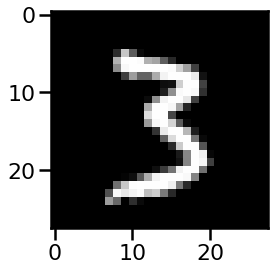

In [10]:
#render an image from the preprocessed data

import matplotlib.pyplot as plt
plt.imshow(sample_batch['x'][0].reshape(28,28), cmap='gray', aspect='equal')

In [11]:
#define function to transform datasets into federated system data

def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [12]:
#create the federated data
federated_training_data = make_federated_data(train_data, [0,1,2,3,4,5,6,7,8,9])
#print number of client datasets and first dataset
print('Number of client datasets: {l}'.format(l=len(federated_training_data)))
print('First dataset: {d}'.format(d=federated_training_data[0]))

<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.uint8), (y, tf.int32)])>


In [13]:
#define function to create Keras model -- this will be the federated model
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

In [14]:
#define function to instantiate keras model as a federated learning model
#pass keras model, preprocessed_example_dataset, loss function, and metrics into tff.learning.from_keras_model
def model_fn():
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
     input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [15]:
#build federated process
#define the server-side and client-side optimizers
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.1))

In [16]:
#initialize federated learning process
state = iterative_process.initialize()

In [17]:
#define number of iterations
NUM_ROUNDS = 51
#perform federated learning process
for round_num in range(1, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_training_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.98684), ('loss', 0.2065878)])), ('stat', OrderedDict([('num_examples', 500000)]))])
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.987604), ('loss', 0.19884218)])), ('stat', OrderedDict([('num_examples', 500000)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.988318), ('loss', 0.18743905)])), ('stat', OrderedDict([('num_examples', 500000)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.989352), ('loss', 0.1706

# Model Testing

The following code blocks extract the global federated model resulting from the above training and test its ability to recover from a system fault. A full description of the fault simulation is available in the publication.

In [18]:
#print out the current model state after federated training process has terminated
state.model

ModelWeights(trainable=[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([-2.6840055,  1.9107808,  3.5902402, -3.1839533,  2.9094949,
        3.1530716, -1.5532839,  3.2383664, -2.8752456, -3.715394 ],
      dtype=float32)], non_trainable=[])

In [19]:
#instantiate a new model
md1 = create_keras_model()

#set the model weights to be equal to the current global federated model
md1.set_weights(state.model.trainable)

#display a summary of the current model
md1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [20]:
#compile the initialized model using the same optimization settings defined in the client-side optimizer
md1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

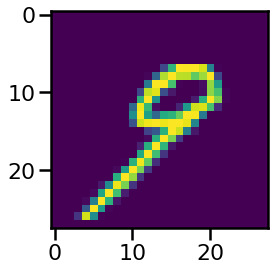

In [21]:
#create a testing a training set from the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#reshape the data to the correct format
x_train_proc = tf.reshape(x_train, [-1, 784])
x_test_proc = tf.reshape(x_test, [-1, 784])
y_train_proc = tf.reshape(y_train, [-1, 1])
y_test_proc =  tf.reshape(y_test, [-1, 1])

#display an example image in the training set
plt.imshow(x_train[501])

In [22]:
#use the global model to predict on the test set
federated_model_test = np.argmax(md1.predict(x_test_proc), axis=-1)

#calculate the accuracy of the prediction
accuracy_score(y_test, federated_model_test)


0.8907

In [23]:
#create index masks for each number in the training and testing set
#these will be used to extract specific digits for simulating the scenarios defined in the publication

a1= (y_train == 0)
b1 = (y_train == 1)
c1 = (y_train == 2)
d1= (y_train == 3)
e1 = (y_train == 4)
f1 = (y_train == 5)
g1= (y_train == 6)
h1 = (y_train == 7)
i1 = (y_train == 8)
j1= (y_train == 9)

a2= (y_test == 0)
b2 = (y_test == 1)
c2 = (y_test == 2)
d2= (y_test == 3)
e2 = (y_test == 4)
f2 = (y_test == 5)
g2= (y_test == 6)
h2 = (y_test == 7)
i2 = (y_test == 8)
j2 = (y_test == 9)

In [24]:
#create dataset for scenario 1 - even numbers
y_train_scenario_1 = y_train_proc[a1+c1+e1+g1+i1]
x_train_scenario_1 = x_train_proc[a1+c1+e1+g1+i1]

y_test_scenario_1 = y_test_proc[a2+c2+e2+g2+i2]
x_test_scenario_1 = x_test_proc[a2+c2+e2+g2+i2]


In [25]:
#create a local model for the scenario testing
#this model has oly local knowledge and is therefore only trained on even numbers
#during the simulated scenarios, odd numbers will be periodically added to the dataset. 
md_scenario_1 = tf.keras.models.Sequential([ tf.keras.layers.Input(shape = (784,)),
                                  tf.keras.layers.Dense(10, kernel_initializer ='zeros'),
                                  tf.keras.layers.Softmax()])

#compile the model using the same optimizer settings as the global model
md_scenario_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

#fit the model on the scenario training data
md_scenario_1.fit(x_train_scenario_1,y_train_scenario_1)

#predict on the scenario testing data
scenario_1_pred = np.argmax(md_scenario_1.predict(x_test_scenario_1), axis=-1)

#calculate the scenario accuracy
performance_init = accuracy_score(y_test_scenario_1, scenario_1_pred)

922/922 [==============================] - 1s 1ms/step - loss: 349.5738 - sparse_categorical_accuracy: 0.8863


In [26]:
#define the remaining scenarios -- incremental addition of odd numbers to the test set

# even + 1
y_test_scenario_5 = y_test_proc[a2+c2+e2+g2+i2+b2]
x_test_scenario_5 = x_test_proc[a2+c2+e2+g2+i2+b2]

#even + 1, 3
y_test_scenario_6 = y_test_proc[a2+c2+e2+g2+i2+b2+d2]
x_test_scenario_6 = x_test_proc[a2+c2+e2+g2+i2+b2+d2]

#even + 1, 3, 5
y_test_scenario_7 = y_test_proc[a2+c2+e2+g2+i2+b2+d2+f2]
x_test_scenario_7 = x_test_proc[a2+c2+e2+g2+i2+b2+d2+f2]

#even + 1, 3, 5, 7
y_test_scenario_8 = y_test_proc[a2+c2+e2+g2+i2+b2+d2+f2+h2]
x_test_scenario_8 = x_test_proc[a2+c2+e2+g2+i2+b2+d2+f2+h2]

#even + 1, 3, 5, 7, 9
y_test_scenario_9 = y_test_proc[a2+c2+e2+g2+i2+b2+d2+f2+h2+j2]
x_test_scenario_9 = x_test_proc[a2+c2+e2+g2+i2+b2+d2+f2+h2+j2]

In [27]:
#local model prediction on the various scenarios defined aboved
sc1 = []

scenario_5_pred = np.argmax(md_scenario_1.predict(x_test_scenario_5), axis=-1)
sc1.append(accuracy_score(y_test_scenario_5, scenario_5_pred))

scenario_6_pred = np.argmax(md_scenario_1.predict(x_test_scenario_6), axis=-1)
sc1.append(accuracy_score(y_test_scenario_6, scenario_6_pred))

scenario_7_pred = np.argmax(md_scenario_1.predict(x_test_scenario_7), axis=-1)
sc1.append(accuracy_score(y_test_scenario_7, scenario_7_pred))

scenario_8_pred = np.argmax(md_scenario_1.predict(x_test_scenario_8), axis=-1)
sc1.append(accuracy_score(y_test_scenario_8, scenario_8_pred))

scenario_9_pred = np.argmax(md_scenario_1.predict(x_test_scenario_9), axis=-1)
sc1.append(accuracy_score(y_test_scenario_9, scenario_9_pred))

In [28]:
#recovery scenario 1 -- federated global model
rs_1 = []
#use the global model in place of the local model 
scenario_1_1_rec_pred = np.argmax(md1.predict(x_test_scenario_9), axis=-1)
rs_1.append(accuracy_score(y_test_scenario_9, scenario_1_1_rec_pred))
#performance remains constant across all fault recovery timesteps 
rs_1 = 6*rs_1


In [29]:
# recovery sceario 2 -- train a local model from scratch

#instantiate new model
md_recovery_2 = tf.keras.models.Sequential([ tf.keras.layers.Input(shape = (784,)),
                                  tf.keras.layers.Dense(10, kernel_initializer ='zeros'),
                                  tf.keras.layers.Softmax()])
md_recovery_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

#perform 5 training iterations 
hist2 = md_recovery_2.fit(x_train_proc[1:500], y_train_proc[1:500], epochs = 5, validation_data=(x_test_scenario_9,y_test_scenario_9))
rs_2 = hist2.history['val_sparse_categorical_accuracy']

Epoch 1/5
16/16 [==============================] - 1s 59ms/step - loss: 1713.4021 - sparse_categorical_accuracy: 0.3504 - val_loss: 747.0728 - val_sparse_categorical_accuracy: 0.6421
Epoch 2/5
16/16 [==============================] - 0s 21ms/step - loss: 394.0617 - sparse_categorical_accuracy: 0.7586 - val_loss: 450.8682 - val_sparse_categorical_accuracy: 0.7058
Epoch 3/5
16/16 [==============================] - 0s 22ms/step - loss: 93.9597 - sparse_categorical_accuracy: 0.9048 - val_loss: 521.5106 - val_sparse_categorical_accuracy: 0.6743
Epoch 4/5
16/16 [==============================] - 0s 22ms/step - loss: 74.6326 - sparse_categorical_accuracy: 0.9345 - val_loss: 324.0416 - val_sparse_categorical_accuracy: 0.7609
Epoch 5/5
16/16 [==============================] - 0s 22ms/step - loss: 72.1291 - sparse_categorical_accuracy: 0.8962 - val_loss: 417.5116 - val_sparse_categorical_accuracy: 0.7555


In [30]:
#recovery scenario 3 -- previous model re-instantiation + training

#perform 5 training iterations
hist3 = md_scenario_1.fit(x_train_proc[1:500], y_train_proc[1:500], epochs = 5, validation_data=(x_test_scenario_9,y_test_scenario_9))
rs_3 = [sc1[-1]] + hist3.history['val_sparse_categorical_accuracy']

Epoch 1/5
16/16 [==============================] - 0s 29ms/step - loss: 1403.0320 - sparse_categorical_accuracy: 0.5932 - val_loss: 471.2638 - val_sparse_categorical_accuracy: 0.7407
Epoch 2/5
16/16 [==============================] - 0s 22ms/step - loss: 178.6162 - sparse_categorical_accuracy: 0.8798 - val_loss: 451.4392 - val_sparse_categorical_accuracy: 0.7111
Epoch 3/5
16/16 [==============================] - 0s 22ms/step - loss: 77.6940 - sparse_categorical_accuracy: 0.9118 - val_loss: 288.0914 - val_sparse_categorical_accuracy: 0.8121
Epoch 4/5
16/16 [==============================] - 0s 21ms/step - loss: 42.0449 - sparse_categorical_accuracy: 0.9399 - val_loss: 390.3116 - val_sparse_categorical_accuracy: 0.7588
Epoch 5/5
16/16 [==============================] - 0s 22ms/step - loss: 36.8379 - sparse_categorical_accuracy: 0.9459 - val_loss: 327.8441 - val_sparse_categorical_accuracy: 0.8122


#Graphing and Visualization

The following code block display the visualization generated from the above results.

In [31]:
# define initial model performance
initial_performance = {'time':[1,2,3,4,5],
                       'performance':[performance_init,performance_init,performance_init,performance_init,performance_init]}

# define performance during transition scenarios 
s1_performance = {'time':[6,7,8,9,10],
                       'performance':sc1}             

#define performance during fault

fault_performance = {'time':[11,12,13,14,15],
                     'performance':[0,0,0,0,0]}

#pre recovery performance
data = pd.DataFrame(initial_performance).append(pd.DataFrame(s1_performance), ignore_index = True).append(pd.DataFrame(fault_performance), ignore_index = True)    

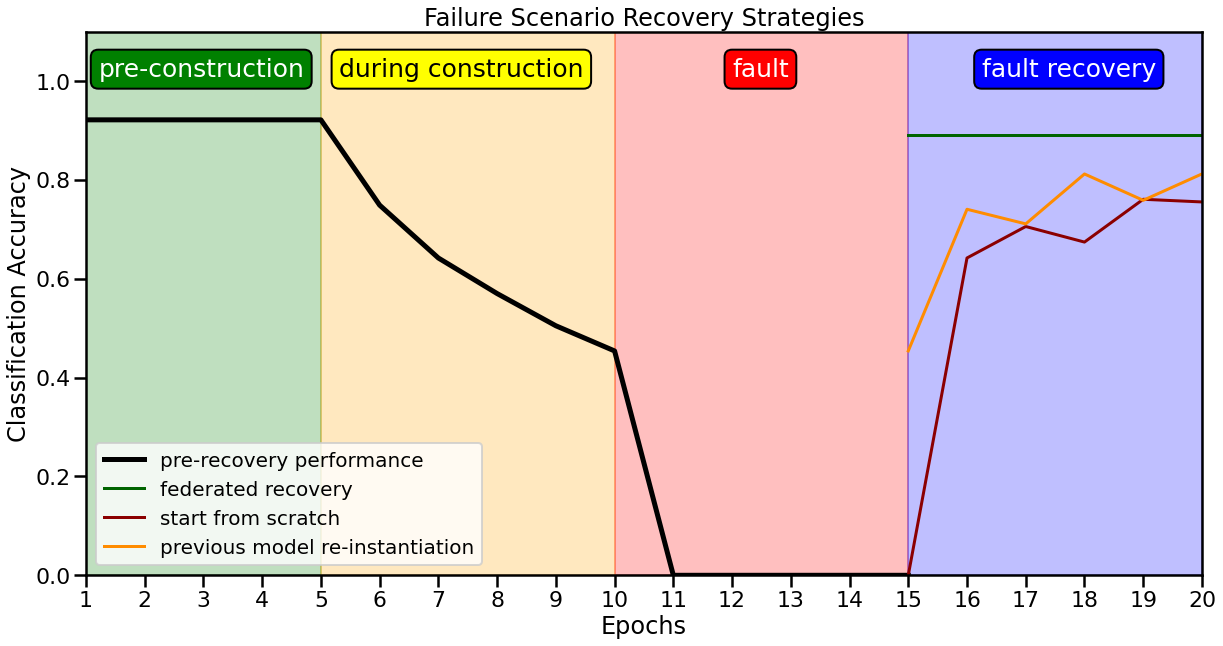

In [32]:
#create figure
fig = plt.figure(figsize = (20,10))
plt.plot(data['time'], data['performance'], color = 'black',lw = 5, label = 'pre-recovery performance' )
plt.xlabel('Epochs')
plt.xlim(1,20)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.ylabel('Classification Accuracy')
plt.ylim(0,1.1)
plt.yticks()
plt.title('Failure Scenario Recovery Strategies')
plt.axvspan(1,5, color = 'green', alpha = 0.25)
plt.axvspan(5,10, color = 'orange', alpha = 0.25)
plt.axvspan(10,15, color = 'red', alpha = 0.25)
plt.axvspan(15,20, color = 'blue', alpha = 0.25)


area_labels = ['pre-construction', 'during construction', 'fault', 'fault recovery']
props1 =  dict(boxstyle='round', facecolor='green', alpha=1)
props2 =  dict(boxstyle='round', facecolor='yellow', alpha=1)
props3 =  dict(boxstyle='round', facecolor='red', alpha=1)
props4 =  dict(boxstyle='round', facecolor='blue', alpha=1)
plt.text(1.21,1.01,area_labels[0], size=10, bbox =  props1 , fontsize  =25, color = 'white')
plt.text(5.31,1.01,area_labels[1], size=10, bbox =  props2 , fontsize  =25, color = 'black')
plt.text(12,1.01,area_labels[2], size=10, bbox =  props3 , fontsize  =25, color = 'white')
plt.text(16.25,1.01,area_labels[3], size=10, bbox =  props4 , fontsize  =25, color = 'white')

#plot post recovery performance
rs_2.insert(0,0)
plt.plot( [15,16,17,18,19,20], rs_1, color = 'darkgreen', lw = 3, label = 'federated recovery')
plt.plot( [15,16,17,18,19,20], rs_2, color = 'darkred', lw = 3, label = 'start from scratch')
plt.plot( [15,16,17,18,19,20], rs_3, color = 'darkorange', lw = 3, label = 'previous model re-instantiation')

plt.legend(fontsize = 20, loc =3)

In [33]:
#save figure 
fig.savefig('Failure_Scenario_Recovery_Strategies_Final.png', dpi = 300, bbox = 'tight')